# Field Analysis Automated Reassignment

This demo will show the method for automatically reassigning the position of combiners within a plant, based on the output of the `field` routines. The automated method described here was reported in a conference article: 
- J. Ranalli and W. Hobbs, "Automating Methods for Validating PV Plant Equipment Labels", 2024, IEEE PV Specialists Conference.  

The demo will use the data from Sample Plant 1, which is an approximately 20 MW plant with data separated by combiners. Based on operational experience from the plant, it is highly likely that mislabeling of combiners has occurred and is limited to combiners that share the same inverter. So for the purpose of this demonstration, we will perform the analyses on a single inverter at a time. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from solarspatialtools import spatial, field

## Load the Data
The approach used here relies on `compute_predicted_position`, so the initial approach to the method is similar to that demonstrated by `field_demo`. We will load data for the sample plant for two separate time windows. The CMVs at these time windows have already been calculated, and so are just manually specified here. 

In [2]:
datafile = "data/sample_plant_1.h5"
# Two hourly combiner current time series
ts_data_a = pd.read_hdf(datafile, mode="r", key="data_a").infer_objects()
ts_data_c = pd.read_hdf(datafile, mode="r", key="data_c").infer_objects()

# Two CMVs corrsponding to those two hours
cmv_a = spatial.pol2rect(10.7, 3.29)
cmv_c = spatial.pol2rect(3.14, 1.92)

# The plant layout
pos_utm = pd.read_hdf(datafile, mode="r", key="utm").infer_objects()

## Compute Positions for the Target Inverter
This method was first reported in a 2024 Journal of Photovoltaics paper. As part of the development of the method, field verifications of the predictions were made, as reported in:
- J. Ranalli and W. Hobbs, 2024, "PV Plant Equipment Labels and Layouts Can Be Validated by Analyzing Cloud Motion in Existing Plant Measurements", IEEE Journal of Photovoltaics. 

For the sample plant, Inverter 20 was known to have significant mislabeling, so we will target that Inverter with this demonstration. For each of those combiners, we will apply `compute_predicted_position` to predict its position as inferred from the delay calculations. Since this operates on a single combiner at a time, we need to store the predictions in a DataFrame.  

The plot below shows the predictions for each combiner in Inverter 20. The red line connects the expected position of the combiner to the predicted position. As evident, most of the combiners appear to be mixed up. 

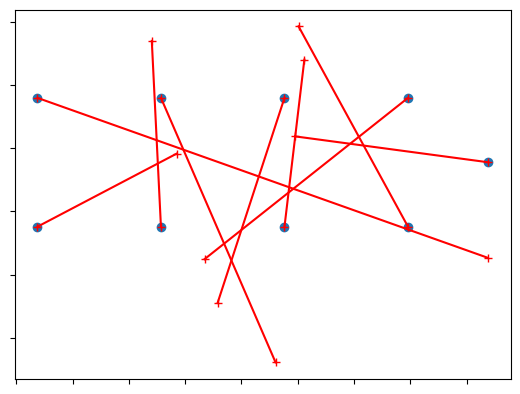

In [3]:
# Get the names for all combiners in Inverter 20
refs = [nm for nm in pos_utm.index if nm.split('-')[1] in ['20']]

# Predict the position of each combiner
preds_r0 = pd.DataFrame(index=refs, columns=['E', 'N'], dtype=float)
for ref in refs:
    pos, _ = field.compute_predicted_position([ts_data_a, ts_data_c], pos_utm, ref,[cmv_a, cmv_c])
    preds_r0.loc[ref] = pos


plotdf = pd.DataFrame({'E': pos_utm['E'].loc[refs], 'N': pos_utm['N'].loc[refs], 'E-delay': preds_r0['E'], 'N-delay': preds_r0['N']}, index=refs, dtype=float)
plt.scatter(pos_utm.loc[refs]['E'], pos_utm.loc[refs]['N'])
plt.plot(plotdf[['E', 'E-delay']].values.T, plotdf[['N', 'N-delay']].values.T, 'r-+')
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])
plt.show()

## Reassigning Combiner Positions
Automatically reassigning the positions of the combiners is done by a solver for the [Assignment Problem](https://en.wikipedia.org/wiki/Assignment_problem), using the sum distance between combiners and their predicted positions as a cost function. The solver is implemented in the `field` module as `assign_positions`. The method requires the expected positions of the combiners (i.e. from the plant design plans) and the predicted positions of the combiners. 

The `assign_positions` function returns a list of tuples that indicate the remapping of the listed combiner positions (shown as a DataFrame below). The first element of the tuple specifies a combiner. The second element specifies the combiner whose position should replace the original position of the first element. This can be a little bit confusing, so a helper (`remap_positions`) is provided to convert the `pos_utm` positions according to these indices. The two plots below show the before and after positions of the combiners.

In [4]:
# Compute the remapping
remap_inds_r0, _ = field.assign_positions(pos_utm.loc[refs], preds_r0)
print(pd.DataFrame(remap_inds_r0, columns=['Combiner ID', 'Copy Position From']))

# Apply the remapping to the plant layout
pos_utm_r1 = field.remap_positions(pos_utm, remap_inds_r0)


  Combiner ID Copy Position From
0   CMB-20-01          CMB-20-09
1   CMB-20-02          CMB-20-07
2   CMB-20-03          CMB-20-05
3   CMB-20-04          CMB-20-06
4   CMB-20-05          CMB-20-02
5   CMB-20-06          CMB-20-01
6   CMB-20-07          CMB-20-03
7   CMB-20-08          CMB-20-04
8   CMB-20-09          CMB-20-08


## Visualize the Reassignment
Here we just visualize what happens when we reassign the predicted combiner positions to their nearest predicted position. The plot on the left shows the initial predictions, while the plot on the right shows the reassignment. This significantly reduces the apparent confusion in the combiner positions, subject to an important caveat that we'll look at later. 

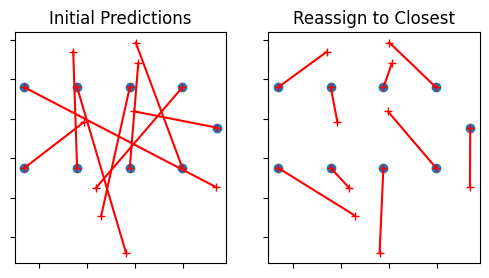

In [5]:
plotdf = pd.DataFrame({'E': pos_utm['E'].loc[refs], 'N': pos_utm['N'].loc[refs], 'E-delay': preds_r0['E'], 'N-delay': preds_r0['N']}, index=refs, dtype=float)
plotdf2 = pd.DataFrame({'E': pos_utm_r1['E'].loc[refs], 'N': pos_utm_r1['N'].loc[refs], 'E-delay': preds_r0['E'], 'N-delay': preds_r0['N']}, index=refs, dtype=float)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(6, 3))
ax0.set_title('Initial Predictions')
ax0.scatter(pos_utm['E'].loc[refs], pos_utm['N'].loc[refs])
ax0.plot(plotdf[['E', 'E-delay']].values.T, plotdf[['N', 'N-delay']].values.T, 'r-+')
ax0.xaxis.set_ticklabels([])
ax0.yaxis.set_ticklabels([])

ax1.set_title('Reassign to Closest')
ax1.scatter(pos_utm['E'].loc[refs], pos_utm['N'].loc[refs])
ax1.plot(plotdf2[['E', 'E-delay']].values.T, plotdf2[['N', 'N-delay']].values.T, 'r-+')
ax1.xaxis.set_ticklabels([])
ax1.yaxis.set_ticklabels([])

plt.show()

## Updating Predictions with Reassignment
The ability to make predictions of position based on the delay relies on the assumption that the combiners are correctly labeled. So that means that the reassignment is only as good as the initial predictions. In fact, if we recalculate positions based on a plant with the initial reassignment applied, we might get different results for the predicted positions. This effect is primarily influenced by the updated distances between combiners that are used within `compute_predicted_position`. 

Here's an example of updating those predictions. Notice that the only real difference with the previous code is that we specify the updated positions in the `pos_utm_r1` DataFrame instead of the initial values in `pos_utm`.

In the plot below, we can see that between the middle and right-most frames, there is a change between where each combiner is predicted to be. This is a result of the updated assumed combiner positions. We can imagine that using this process iteratively can allow us to reach a converged solution for the combiner positions.  

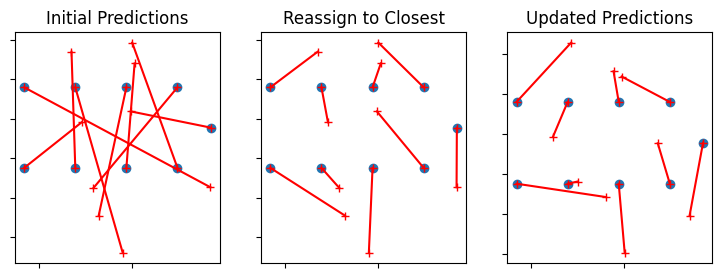

In [6]:
# Rerun the field calculation with the remapped positions
preds_r1 = pd.DataFrame(index=refs, columns=['E', 'N'], dtype=float)
for ref in refs:
    pos, _ = field.compute_predicted_position([ts_data_a, ts_data_c], pos_utm_r1, ref,[cmv_a, cmv_c])
    preds_r1.loc[ref] = pos

# Update a plot to show the revised positions
plotdf3 = pd.DataFrame({'E': pos_utm_r1['E'].loc[refs], 'N': pos_utm_r1['N'].loc[refs], 'E-delay': preds_r1['E'], 'N-delay': preds_r1['N']}, index=refs, dtype=float)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(9, 3))
ax0.set_title('Initial Predictions')
ax0.scatter(pos_utm['E'].loc[refs], pos_utm['N'].loc[refs])
ax0.plot(plotdf[['E', 'E-delay']].values.T, plotdf[['N', 'N-delay']].values.T, 'r-+')
ax0.xaxis.set_ticklabels([])
ax0.yaxis.set_ticklabels([])

ax1.set_title('Reassign to Closest')
ax1.scatter(pos_utm['E'].loc[refs], pos_utm['N'].loc[refs])
ax1.plot(plotdf2[['E', 'E-delay']].values.T, plotdf2[['N', 'N-delay']].values.T, 'r-+')
ax1.xaxis.set_ticklabels([])
ax1.yaxis.set_ticklabels([])

ax2.set_title('Updated Predictions')
ax2.scatter(pos_utm['E'].loc[refs], pos_utm['N'].loc[refs])
ax2.plot(plotdf3[['E', 'E-delay']].values.T, plotdf3[['N', 'N-delay']].values.T, 'r-+')
ax2.xaxis.set_ticklabels([])
ax2.yaxis.set_ticklabels([])

plt.show()

## Iterating to Solve for Final Positions
Given these updated positions, we can again use `assign_positions` to compute the optimized mapping of combiner positions. There's one tricky part of this step though, namely that our coordinate system has changed. Since we initially applied the remapping to the combiners to compute these remapped indices, what we're left with is essentially a remap of a remap. Again, because this is likely to lead to confusion, a function called `cascade_remap` is provided to handle converting the second list of remapped indices back to the original `pos_utm` coordinate reference. 

To determine whether our solution has converged, we can compare the remapped indices from the first and second iterations. If they are the same, then we have reached a stable solution. In this case, it has not, so we could try another iteration. 


In [7]:
remap_inds_r1, _ = field.assign_positions(pos_utm_r1.loc[refs], preds_r1)  # Remap of remap
remap_inds_r1 = field.cascade_remap(remap_inds_r0, remap_inds_r1)  # Convert back to initial coord system

print(pd.DataFrame(remap_inds_r1, columns=['Combiner ID', 'Copy Position From']))
print(f"\nHas the remap stayed the same after recalculating? {remap_inds_r1 == remap_inds_r0}")

  Combiner ID Copy Position From
0   CMB-20-01          CMB-20-09
1   CMB-20-02          CMB-20-08
2   CMB-20-03          CMB-20-07
3   CMB-20-04          CMB-20-06
4   CMB-20-05          CMB-20-05
5   CMB-20-06          CMB-20-01
6   CMB-20-07          CMB-20-02
7   CMB-20-08          CMB-20-03
8   CMB-20-09          CMB-20-04

Has the remap stayed the same after recalculating? False


In [8]:
# Update the plant layout again and recalculate again.
pos_utm_r2 = field.remap_positions(pos_utm, remap_inds_r1)
preds_r2 = pd.DataFrame(index=refs, columns=['E', 'N'], dtype=float)
for ref in refs:
    pos, _ = field.compute_predicted_position([ts_data_a, ts_data_c], pos_utm_r2, ref,[cmv_a, cmv_c])
    preds_r2.loc[ref] = pos

# Redo the assignment and redo the coordinate system cascade
remap_inds_r2, _ = field.assign_positions(pos_utm_r2.loc[refs], preds_r2)
remap_inds_r2 = field.cascade_remap(remap_inds_r1, remap_inds_r2)

print(pd.DataFrame(remap_inds_r1, columns=['Combiner ID', 'Copy Position From']))
print(f"\nHas the remap stayed the same after recalculating? {remap_inds_r2 == remap_inds_r1}")

  Combiner ID Copy Position From
0   CMB-20-01          CMB-20-09
1   CMB-20-02          CMB-20-08
2   CMB-20-03          CMB-20-07
3   CMB-20-04          CMB-20-06
4   CMB-20-05          CMB-20-05
5   CMB-20-06          CMB-20-01
6   CMB-20-07          CMB-20-02
7   CMB-20-08          CMB-20-03
8   CMB-20-09          CMB-20-04

Has the remap stayed the same after recalculating? True


## Solution is Converged
At this point, we've reached a consistent solution for the combiner positions. This solution matches with what was found by manual inspection of the plant. Reaching this solution took us two cycles through the `field` calculation to reach the final positions, along with a third to verify that nothing had changed. In some cases, it's possible for the solution to oscillate between two different positions, so it's important to set a limit on any iteration. Failure to converge would basically indicate that the two possible positions are equally possible to within the uncertainty of the field analysis methodology, so it's possible that further improvements to reduce the uncertainty may lead to an approach for eliminating those conditions. 


## Visualizing the Iterative Process
The plots below show the three iterations of the combiner positions that were necessary to converge this case. In each row, the left plot shows the initial predictions, the middle plot shows the reassignment to the closest combiner, and the right plot shows the recalculated positions.  

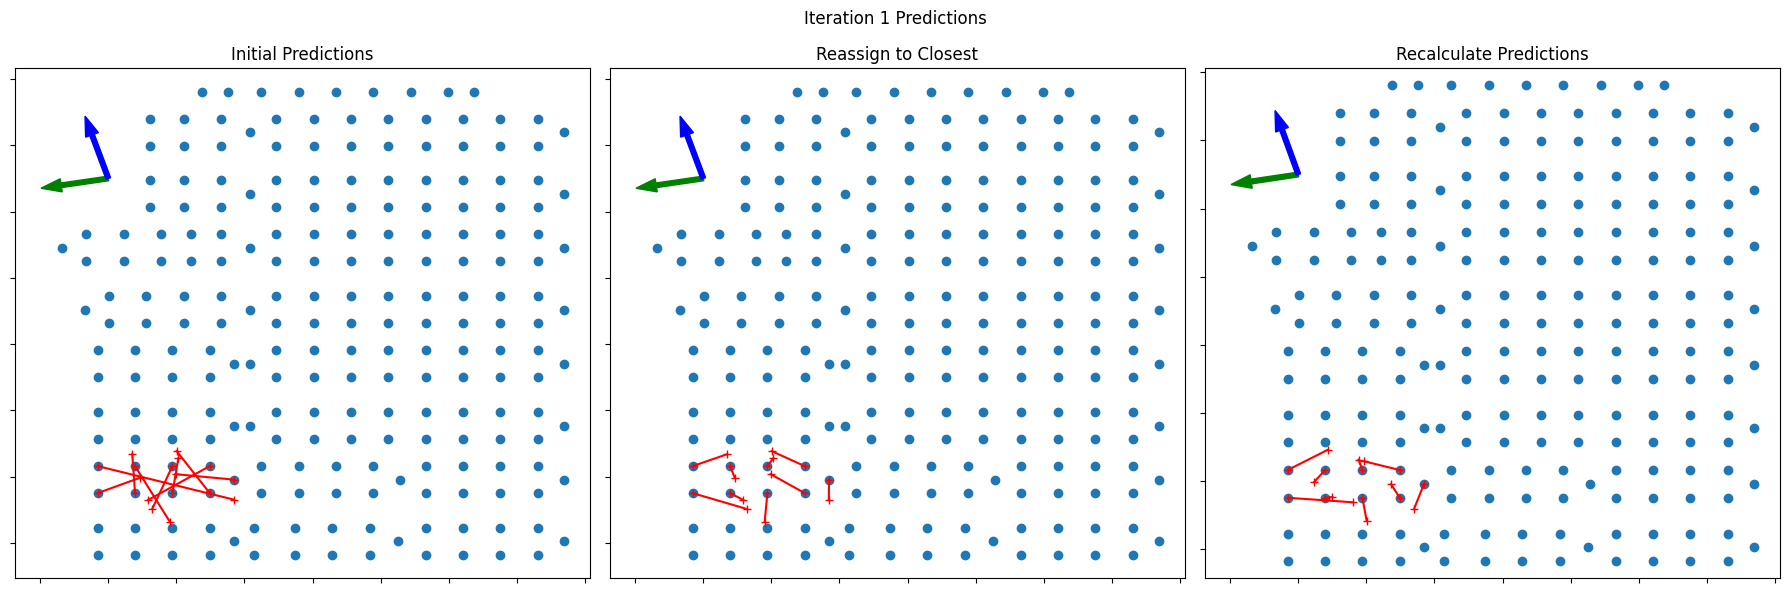

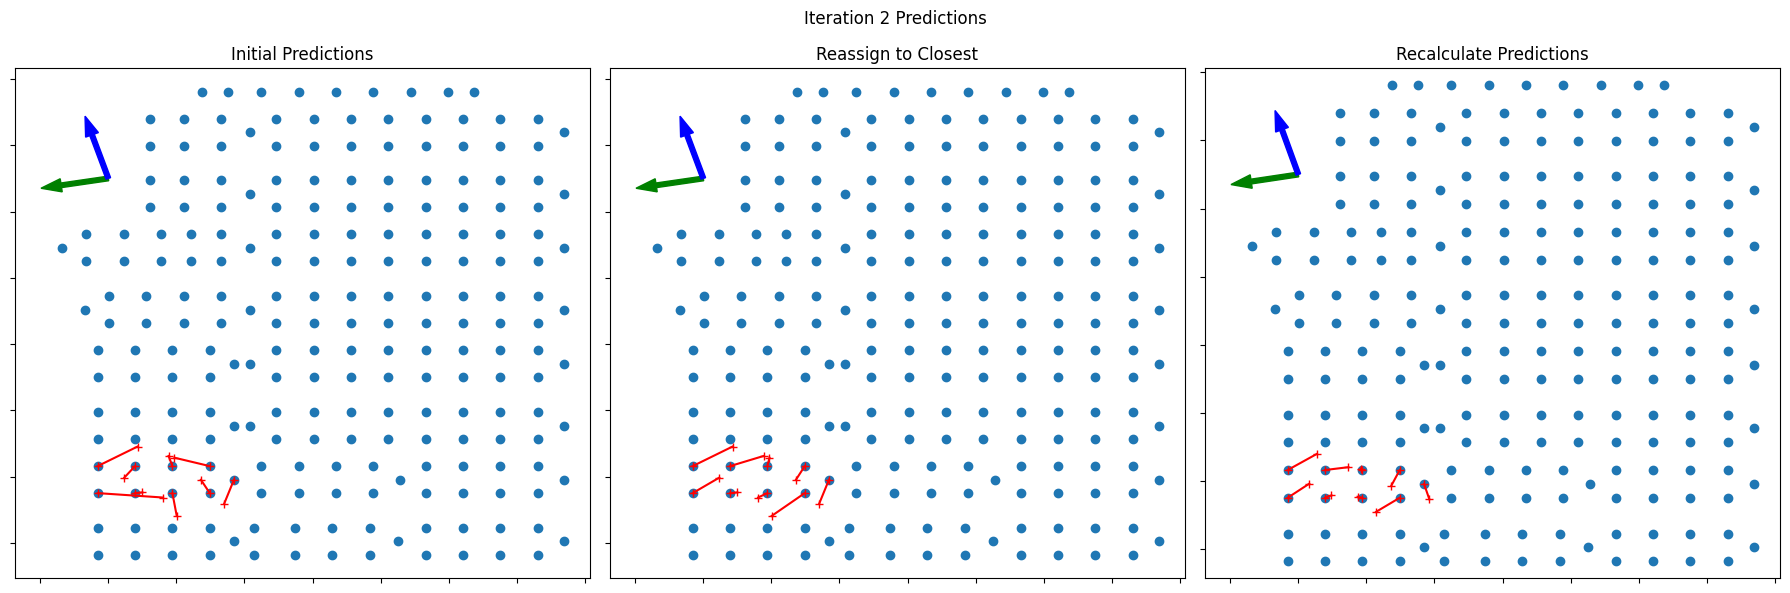

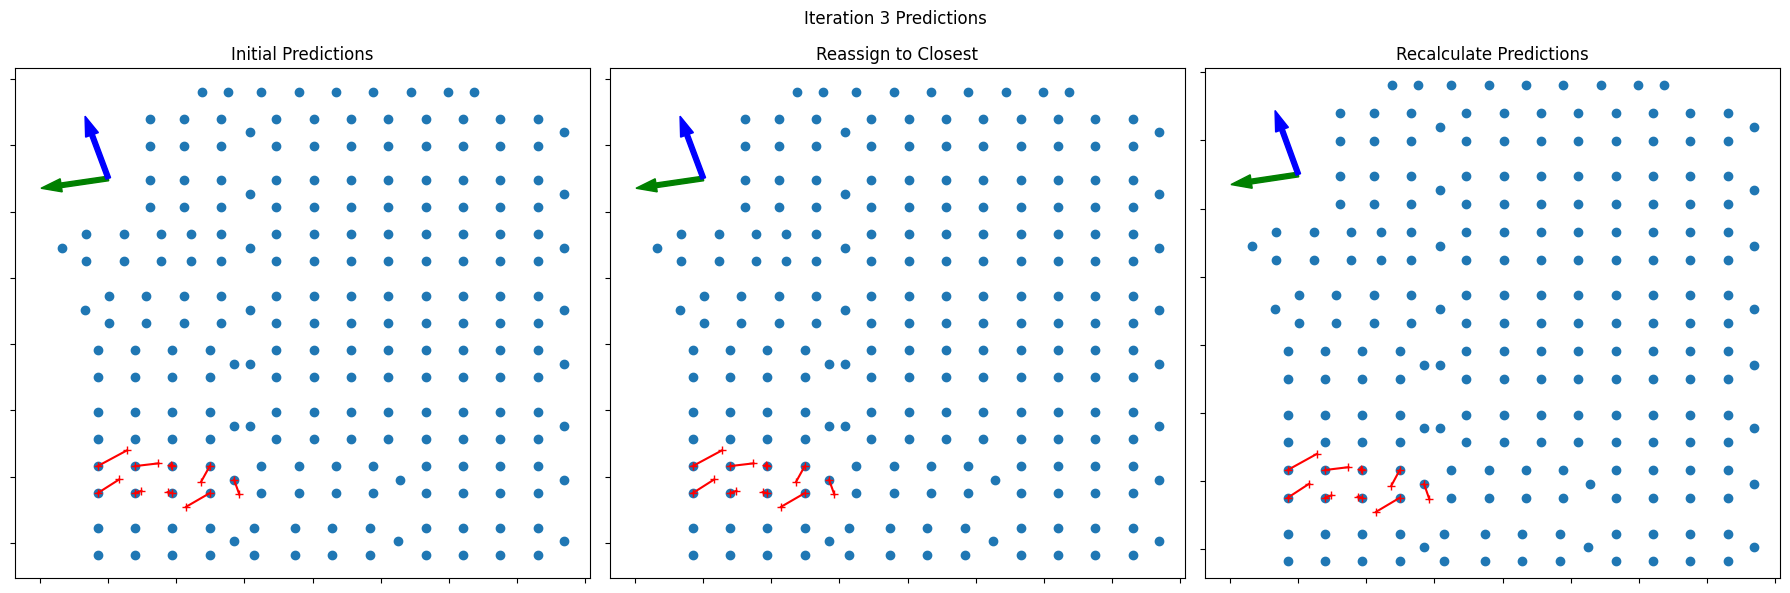

In [9]:
for i, (init_pos, remap_pos, pred_pos, next_pred) in enumerate(zip([pos_utm, pos_utm_r1, pos_utm_r2], [pos_utm_r1, pos_utm_r2, pos_utm_r2], [preds_r0, preds_r1, preds_r2], [preds_r1, preds_r2, preds_r2])):
    # Just creating some helper variables for the plot
    initial = pd.DataFrame({'E': init_pos['E'].loc[refs], 'N': init_pos['N'].loc[refs], 'E-delay': pred_pos['E'], 'N-delay': pred_pos['N']}, index=refs, dtype=float)
    reassigned = pd.DataFrame({'E': remap_pos['E'].loc[refs], 'N': remap_pos['N'].loc[refs], 'E-delay': pred_pos['E'], 'N-delay': pred_pos['N']}, index=refs, dtype=float)
    recalculated = pd.DataFrame({'E': remap_pos['E'].loc[refs], 'N': remap_pos['N'].loc[refs], 'E-delay': next_pred['E'], 'N-delay': next_pred['N']}, index=refs, dtype=float)

    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(18, 6))

    ax0.set_title('Initial Predictions')
    ax0.scatter(pos_utm['E'], pos_utm['N'])
    ax0.plot(initial[['E', 'E-delay']].values.T, initial[['N', 'N-delay']].values.T, 'r-+')
    ax0.xaxis.set_label('E')
    ax0.yaxis.set_label('N')
    ax0.xaxis.set_ticklabels([])
    ax0.yaxis.set_ticklabels([])

    ax1.set_title('Reassign to Closest')
    ax1.scatter(pos_utm['E'], pos_utm['N'])
    ax1.plot(reassigned[['E', 'E-delay']].values.T, reassigned[['N', 'N-delay']].values.T, 'r-+')
    ax1.xaxis.set_label('E')
    ax1.yaxis.set_label('N')
    ax1.xaxis.set_ticklabels([])
    ax1.yaxis.set_ticklabels([])

    ax2.set_title('Recalculate Predictions')
    ax2.scatter(pos_utm['E'], pos_utm['N'])
    ax2.plot(recalculated[['E', 'E-delay']].values.T, recalculated[['N', 'N-delay']].values.T, 'r-+')
    ax2.xaxis.set_label('E')
    ax2.yaxis.set_label('N')
    ax2.xaxis.set_ticklabels([])
    ax2.yaxis.set_ticklabels([])

    # Plot some arrows to show the CMV
    for cmv, color in zip([cmv_a, cmv_c], ['green', 'blue']):
        velvec = np.array(spatial.unit(cmv)) * 100
        ax0.arrow(-200, -150, velvec[0], velvec[1],
                  length_includes_head=True, width=7, head_width=20, color=color)
        ax1.arrow(-200, -150, velvec[0], velvec[1],
                  length_includes_head=True, width=7, head_width=20, color=color)
        ax2.arrow(-200, -150, velvec[0], velvec[1],
                  length_includes_head=True, width=7, head_width=20, color=color)
    # Some plot config
    plt.axis('equal')
    fig.suptitle(f'Iteration {i+1} Predictions')
    plt.tight_layout()

plt.show()
